In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

/home/grad/si/23/caio.grossi/anaconda3/envs/python3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-02 11:20:59.531369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 11:20:59.584458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 11:20:59.594628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 11:20:59.684739: I tensorflow/core/platform/cpu_feature_guard.c

In [2]:
autoencoder = tf.keras.models.load_model('../modelos/autoencoder_model.keras')

I0000 00:00:1727868061.894163  469613 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-02 11:21:02.102775: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/grad/si/23/caio.grossi/anaconda3/envs/python3.12.2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.g

In [3]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                   "exams_part2.hdf5", "exams_part3.hdf5", "exams_part4.hdf5", "exams_part5.hdf5",
                   "exams_part6.hdf5", "exams_part7.hdf5", "exams_part8.hdf5", "exams_part9.hdf5",
                   "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                   "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

# Selecionar normais e doentes
ecg_normal_linhas = dados.index[(dados['trace_file'].isin(arquivos_usados)) & 
                                (dados['normal_ecg'] == True)]

ecg_doente_linhas = dados.index[(dados['trace_file'].isin(arquivos_usados)) & 
                                (dados['1dAVb'] == False) & 
                                (dados['RBBB'] == False) & 
                                (dados['LBBB'] == False) & 
                                (dados['SB'] == 1) & 
                                (dados['ST'] == False) & 
                                (dados['AF'] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ids_proibidos = [ 227806,
187353,
203399,
343089,
317296,
260982 ]

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) & ~dados['exam_id'].isin(ids_proibidos)]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados['trace_file'].isin(arquivos_usados)) & 
                                (dados['1dAVb'] == False) & 
                                (dados['RBBB'] == False) & 
                                (dados['LBBB'] == False) & 
                                (dados['SB'] == 1) & 
                                (dados['ST'] == False) & 
                                (dados['AF'] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

# Separar AS LINHAS do exam.csv em Homens e Mulheres
normais_mulheres = ecg_normal_linhas[dados.loc[ecg_normal_linhas, 'is_male'] == 0]
doentes_mulheres = ecg_doente_linhas[dados.loc[ecg_doente_linhas, 'is_male'] == 0]
normais_homens = ecg_normal_linhas[dados.loc[ecg_normal_linhas, 'is_male'] == 1]
doentes_homens = ecg_doente_linhas[dados.loc[ecg_doente_linhas, 'is_male'] == 1]

# Printando a contagem para checar
print(f"Normais Mulheres: {len(normais_mulheres)}")
print(f"Doentes Mulheres: {len(doentes_mulheres)}")
print(f"Normais Homens: {len(normais_homens)}")
print(f"Doentes Homens: {len(doentes_homens)}")

#Pegando os IDS das linhas separadas
ecg_doente_id_mulheres = dados.iloc[doentes_mulheres, 0].tolist()
ecg_normal_id_mulheres = dados.iloc[normais_mulheres, 0].tolist()
ecg_doente_id_homens = dados.iloc[doentes_homens, 0].tolist()
ecg_normal_id_homens = dados.iloc[normais_homens, 0].tolist()


#Amostrando a quantidade de normais
amostra_normais_mulheres = ecg_normal_id_mulheres[:20000]
amostra_normais_homens = ecg_normal_id_homens[:20000]
amostra_normais_geral = ecg_normal_id_mulheres[:10000] + ecg_normal_id_homens[:10000]

#Selecionando os ids a serem clusterizados
amostra_doentes_homens = ecg_doente_id_homens[:(len(ecg_doente_id_mulheres))]
ids_ecgs = ecg_doente_id_homens + amostra_doentes_mulheres + amostra_normais_geral
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 134657
Número de linhas ecg_doente_linhas: 4890
Tirando Interferência:
Número de linhas ecg_normal_linhas: 130871
Número de linhas ecg_doente_linhas: 4830
Normais Mulheres: 82532
Doentes Mulheres: 1574
Normais Homens: 48339
Doentes Homens: 3256
Número de ecgs pra clusterizar: 24830


In [30]:
#X SE VC ESTIVER NA GÓRGONA
arquivos_hdf5 = ['../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5', '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5', 
              '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5', '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5',
              '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5', '../../../../ecg_clustering/Database_Filtrados/filtered_exams_0_1.hdf5'] # Caminhos para os arquivos HDF5

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

Número de ecgs que eram pra ser processados: 23256
Número total de traçados processados: 23256


In [4]:
#X

epsilon = 1e-10
arquivos_hdf5 = ["../Database/filtered_exams_0_1.hdf5",
                 "../Database/filtered_exams_2_3.hdf5",  "../Database/filtered_exams_4_5.hdf5",
                 "../Database/filtered_exams_6_7.hdf5",  "../Database/filtered_exams_8_9.hdf5",
                 "../Database/filtered_exams_10_11.hdf5",  "../Database/filtered_exams_12_13.hdf5",
                 "../Database/filtered_exams_14_15.hdf5", "../Database/filtered_exams_16_17.hdf5"]

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            # Preencher tracings nulos com epsilon
            exam_tracings = np.nan_to_num(exam_tracings, nan=epsilon)
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

Número de ecgs que eram pra ser processados: 24830
Número total de traçados processados: 24830


In [31]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)
epsilon = 1e-10

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

# Substituir os valores NaN por epsilon
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

/tmp/ipykernel_452246/2665860838.py:8: RuntimeWarning: invalid value encountered in divide
  X = X / np.max(np.abs(X), axis=1, keepdims=True)


727/727 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
(23256, 128, 1)
(23256, 128)


In [32]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

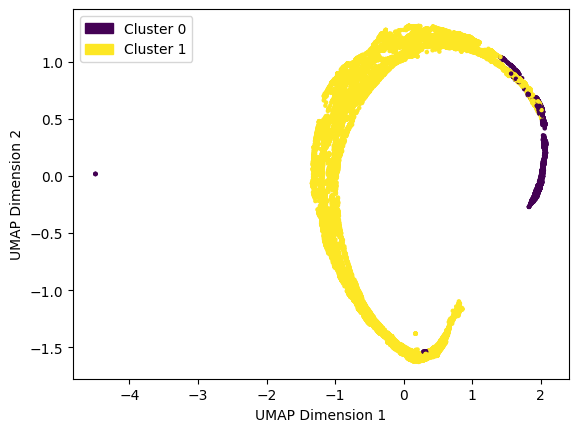

Silhouette Score (Outliers Reassigned): 0.22872820496559143
F1 Score (Outliers Reassigned): 0.7443688167873942
   cluster  1dAVb  RBBB  LBBB    SB  ST  AF  normal_ecg
0        0      0     0     0     3   0   0        2265
1        1      0     0     0  3253   0   0       17735


/tmp/ipykernel_452246/2400459469.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


In [33]:
# CLUSTERIZACAO HDBSCAN DA GORGONA

from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN

# Normalização dos dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Configuração e execução do HDBSCAN
dbscan = HDBSCAN(min_cluster_size=2000, min_samples=1, cluster_selection_epsilon = 1000000000000000000000000, alpha=0.000000000000000000000000000000000000000005)
labels = dbscan.fit_predict(X_reduced_scaled)

# Verificar se há outliers (rótulo -1)
outliers_mask = (labels == -1)

# Inicializar new_labels como uma cópia de labels
new_labels = labels.copy()

if np.any(outliers_mask):
    # Se houver outliers, tratar e realocar ao cluster mais próximo
    # Identificar os outliers
    outliers = X_reduced_scaled[outliers_mask]
    # Identificar os pontos clusterizados (não-outliers)
    clustered_points = X_reduced_scaled[~outliers_mask]
    cluster_labels = labels[~outliers_mask]

    # Encontrar o cluster mais próximo para cada outlier
    closest_clusters, _ = pairwise_distances_argmin_min(outliers, clustered_points)

    # Atribuir os outliers ao cluster mais próximo
    new_labels[outliers_mask] = cluster_labels[closest_clusters]
else:
    print("Nenhum outlier detectado. Usando os rótulos da clusterização original.")

# Visualização dos Resultados com Outliers Reagrupados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=new_labels, cmap='viridis', s=5)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
import matplotlib.patches as mpatches
cluster_0_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label='Cluster 0')
cluster_1_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label='Cluster 1')
plt.legend(handles=[cluster_0_patch, cluster_1_patch], loc='best')
#plt.savefig('SB.jpg')
plt.show()

# Calcular e imprimir os scores com os novos rótulos
silhouette_avg = silhouette_score(X_reduced_scaled, new_labels)
print(f'Silhouette Score (Outliers Reassigned): {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': new_labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, new_labels, average='weighted')
print(f'F1 Score (Outliers Reassigned): {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)


In [34]:
#Verificando informações sobre os exames desviados (Se é Homem ou Mulher) 

# Primeiro, filtramos os exames do cluster NORMAL
normal_cluster_data = merged_data[merged_data['majority_label'] == 'normal']

# Agora, filtramos os exames que têm a doença ST no cluster NORMAL
sb_in_normal_cluster = normal_cluster_data[normal_cluster_data['SB'] == 1]

# Contamos quantos desses exames são de homens e quantos são de mulheres
male_count = sb_in_normal_cluster['is_male'].sum()
female_count = len(sb_in_normal_cluster) - male_count

# Exibimos os resultados
print(f'Exames de SB no cluster NORMAL: {len(sb_in_normal_cluster)}')
print(f'Número de homens: {male_count}')
print(f'Número de mulheres: {female_count}')


Exames de SB no cluster NORMAL: 3256
Número de homens: 3256
Número de mulheres: 0


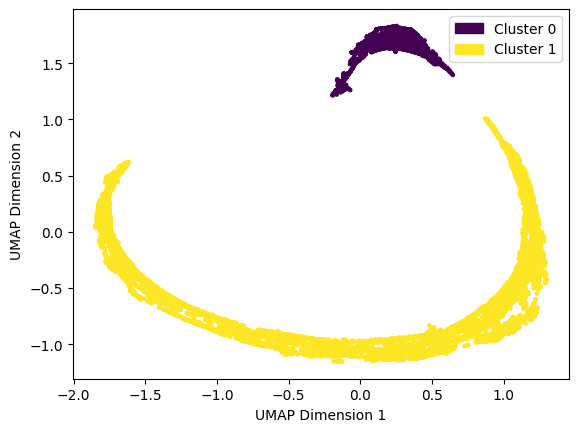

Silhouette Score (Outliers Reassigned): 0.20222200453281403


C:\Users\luisa\AppData\Local\Temp\ipykernel_19956\3118813734.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


F1 Score (Outliers Reassigned): 0.8654909070379615
   cluster  1dAVb  RBBB  LBBB    SB  ST  AF  normal_ecg
0        0      0     0     0  4715   0   0         765
1        1      0     0     0   115   0   0       19235


In [19]:
# CLUSTERIZACAO HDBSCAN LUISA (DO PAPER)

from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN

# Normalização dos dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Configuração e execução do HDBSCAN
dbscan = HDBSCAN(min_cluster_size=2000, min_samples=1, cluster_selection_epsilon = 1000000000000000000000000, alpha=0.000000000000000000000000000000000000000005)
labels = dbscan.fit_predict(X_reduced_scaled)

# Identificar os outliers
outliers_mask = (labels == -1)
outliers = X_reduced_scaled[outliers_mask]

# Identificar os pontos clusterizados (não-outliers)
clustered_points = X_reduced_scaled[~outliers_mask]
cluster_labels = labels[~outliers_mask]

# Encontrar o cluster mais próximo para cada outlier
closest_clusters, _ = pairwise_distances_argmin_min(outliers, clustered_points)

# Atribuir os outliers ao cluster mais próximo
new_labels = labels.copy()
new_labels[outliers_mask] = cluster_labels[closest_clusters]

# Visualização dos Resultados com Outliers Reagrupados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=new_labels, cmap='viridis', s=5)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
import matplotlib.patches as mpatches
cluster_0_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label='Cluster 0')
cluster_1_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label='Cluster 1')
plt.legend(handles=[cluster_0_patch, cluster_1_patch], loc='best')
plt.savefig('SB.jpg')
plt.show()

# Calcular e imprimir os scores com os novos rótulos
silhouette_avg = silhouette_score(X_reduced_scaled, new_labels)
print(f'Silhouette Score (Outliers Reassigned): {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': new_labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, new_labels, average='weighted')
print(f'F1 Score (Outliers Reassigned): {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)


In [8]:
# CALCULAR SILIHUETTE SCORE POR CLUSTER

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score, f1_score, pairwise_distances

#new_labels = labels

# Usar apenas as duas primeiras dimensões
X_reduced_2d = X_reduced_scaled[:, :2]

# Calcular o Silhouette Score médio
silhouette_avg = silhouette_score(X_reduced_2d, new_labels)
print(f'Silhouette Score médio (2D): {silhouette_avg}')

# Calcular o Silhouette Score para cada ponto
silhouette_values = silhouette_samples(X_reduced_2d, new_labels)

# Número de clusters encontrados
n_clusters = len(set(new_labels)) - (1 if -1 in new_labels else 0)

# Criar um DataFrame para os silhouette scores
silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': new_labels,
    'silhouette_score': silhouette_values
})

# Calcular o Silhouette Score médio para cada cluster separado
cluster_silhouette_avg = silhouette_df.groupby('cluster')['silhouette_score'].mean()
print("\nSilhouette Score médio por cluster (2D):")
print(cluster_silhouette_avg)

Silhouette Score médio (2D): 0.4675254225730896

Silhouette Score médio por cluster (2D):
cluster
0    0.884852
1    0.349337
Name: silhouette_score, dtype: float32


In [9]:
# CALCULAR SILHUETT DE CADA PONTO

from sklearn.metrics import silhouette_samples

silhouette_values = 0
silhouette_values = silhouette_samples(X_reduced_scaled, labels)

silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'label': new_labels,
    'silhouette_score': silhouette_values
})

merged_data = silhouette_df.merge(metadata, on='exam_id')

In [10]:
# GERAR CSV RESULTADOS

# GUARDAR EM CSVS

doenca = 'SB'

colunas_desejadas = ['exam_id', 'label', '1dAVb', 'RBBB', 'LBBB' , 'SB' ,'ST' , 'AF', 'normal_ecg', 'silhouette_score']
dados = merged_data[colunas_desejadas]
dados = dados.sort_values(by=['label', 'silhouette_score'], ascending=[True, False])

conditions = [
    (dados['label'] == 0) & (dados[doenca] == True), (dados['label'] == 0) & (dados[doenca] == False),
    (dados['label'] == 1) & (dados[doenca] == True), (dados['label'] == 1) & (dados[doenca] == False),
    (dados['label'] == 2) & (dados[doenca] == True), (dados['label'] == 2) & (dados[doenca] == False),
    (dados['label'] == -1) & (dados[doenca] == True), (dados['label'] == -1) & (dados[doenca] == False)
]
choices = [
    'D_clusterD', 'N_clusterD',
    'D_clusterN','N_clusterN',
    'D_clusterM','N_clusterM',
    'D_clusterO','N_clusterO',
]

dados['tipo'] = np.select(conditions, choices, default='Unknown')

dados.to_csv(f'gerais/{doenca}_geral.csv', index=False)

In [11]:
# SELECIONANDO MAIS DOENTES NO CLUSTER NORMAL

tipos_desejados = ['D_clusterN']
quantidade = 33

def select_evenly_spaced(df, quantidade=quantidade):
    total_rows = len(df)
    if total_rows <= quantidade:
        return df
    else:
        indices = np.linspace(0, total_rows-1, quantidade, dtype=int)
        return df.iloc[indices]

ja_vistos = pd.read_csv(f'resultados/{doenca}.csv')
ids_proibidos = ja_vistos[ja_vistos['tipo'] == 'D_clusterN']['exam_id'].tolist()

dados = dados[dados['tipo'].isin(tipos_desejados)]

dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced)

dados_selecionados = dados_selecionados[~dados_selecionados['exam_id'].isin(ids_proibidos)]

while len(dados_selecionados) < quantidade:
    dados_necessarios = quantidade - len(dados_selecionados)
    outros_dados = dados[~dados['exam_id'].isin(ids_proibidos)]
    adicionais = outros_dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced, quantidade=dados_necessarios)
    dados_selecionados = pd.concat([dados_selecionados, adicionais]).drop_duplicates(subset='exam_id')
    ids_proibidos = dados_selecionados['exam_id'].tolist()

dados_selecionados = dados_selecionados[dados_selecionados['tipo'].isin(tipos_desejados)]

if len(dados_selecionados) < quantidade:
    raise ValueError(f"Não foi possível obter {quantidade} amostras do tipo 'D_clusterN'.")

dados_selecionados.to_csv(f'maisAmostras_d_n/{doenca}_amostras.csv', index=False)


C:\Users\luisa\AppData\Local\Temp\ipykernel_19956\1445605024.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced)
C:\Users\luisa\AppData\Local\Temp\ipykernel_19956\1445605024.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adicionais = outros_dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced, quant

In [12]:
# GERAR AMOSTRAS

def select_25_evenly_spaced(df):
    total_rows = len(df)
    if total_rows <= 25:
        return df
    else:
        indices = np.linspace(0, total_rows-1, 45, dtype=int)
        return df.iloc[indices]
    
ids_ja_vistos = pd.read_csv('')
dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_25_evenly_spaced)

tipos_desejados = ['D_clusterN']
dados_selecionados = dados_selecionados[dados_selecionados['tipo'].isin(tipos_desejados)]

dados_selecionados.to_csv(f'amostras/{doenca}_amostras.csv', index=False)

#PLOTAR AMOSTRAS

def plot_samples(X, exam_ids, labels, title):
    colors = ['gray',    # 0: Other samples
              'yellow',  # 1: D_clusterN
              'orange',  # 2: N_clusterD
              'blue',    # 3: D_clusterM
              'red',     # 4: N_clusterM
              'purple',  # 5: D_clusterO
              'green']   # 6: N_clusterO
    exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
    sample_indices = [exam_id_to_index[exam_id] for exam_id in exam_ids]

    all_labels = np.zeros(X.shape[0])
    all_labels[sample_indices] = labels

    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=1, label='Other samples')
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], c=[colors[label] for label in labels], s=30, edgecolor='k', label='Selected')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(title)
    plt.legend()
    plt.show()

selected_exam_ids = dados_selecionados['exam_id'].values

exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
selected_indices = [exam_id_to_index[exam_id] for exam_id in selected_exam_ids]

labels = [
    1 if tipo == 'D_clusterN' else 2 if tipo == 'N_clusterD' else
    3 if tipo == 'D_clusterM' else 4 if tipo == 'N_clusterM' else
    5 if tipo == 'D_clusterO' else 6 if tipo == 'N_clusterO' else 0
    for tipo in dados_selecionados['tipo'].values
]

plot_samples(X_reduced_scaled, selected_exam_ids, labels, f'Amostras {doenca}')

FileNotFoundError: [Errno 2] No such file or directory: ''

In [28]:
#METRICA Fast-DBCV (PARA O CLUSTERING)
from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from scipy.spatial.distance import euclidean
import dbcv

score = dbcv.dbcv(X_reduced_scaled, labels)
print(score)

0.8826807416248031


In [17]:
#MÉTRICA Cluster Validity Index (CV) (PARA OS CLUSTERS)
from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from scipy.spatial.distance import euclidean
from mydbcv import DBCV, _mutual_reach_dist_graph, _mutual_reach_dist_MST, _cluster_validity_index

#Calculando o grafo completo das distâncias dos pontos
graph = _mutual_reach_dist_graph(X_reduced_scaled, labels, euclidean)

#Calculando do grafo a árvore geradora mínima (MST)
MST = _mutual_reach_dist_MST(graph)

#Calculando o índice de validação do cluster
score = _cluster_validity_index(MST, X_reduced_scaled, labels)
print(score)